### Summary of Results

* On performing LDA, the classes became seperable on the training data after taking the value of K to be greater than
12 but limited to 20 since the number of data points were less than the dimension of a data point (eigen values become zero)


* The classification accuracy on the test dataset was found to be 90% when K was chosen to be from 13-16 and 100% on choosing K value of 16 and 17 (Considerable gap in the extreme points of the projection ). The beahviour worsened later on which might be because of overfitting.

. | . | . | . 
--- | --- | --- | ---
![](images/K13.png)  | ![](images/K14.png) | ![](images/K15.png) | ![](images/K16.png) \\
![](images/K17.png)  | ![](images/K18.png) | ![](images/K19.png) |

Libraries used

* **matplotlib** for plotting graphs
* **numpy** for numerical computations
* **Pillow** for loading images

In [1]:
# Importing the required libraries
import os
import matplotlib.pyplot as plt
import PIL
import numpy as np
import math

## Dataset

The Dataset consisted of 20 images of which 9 images represent the "happy" class and the remaining belonged to the "sad" class. Each image is of dimension 101 x 101 . Therefore flattening it out into a single dimensional vector we get a vector having a dimension size of 10201

In [2]:
'''
Helper class for holding dataset
    *Attributes
        * data_type : holds the type of the dataset (train/test)
        * N : number of image files in the dataset
        * max_pixel_value : holds the maximum value pixel in the dataset
        * n_features : Dimension of the image vector (10201)
        * happy_indices: stores i such that files[i] is a happy images
        * sad_indices : similar to happy_indices for sad images    
        * dataset : a numpy matrix of dimensions = (Number of images) x (Dimensionality of each image) 
'''

class Dataset:
    
    def __init__(self,dataset_type="train/"):
        
        self.data_type = dataset_type
        self.files = os.listdir(dataset_type)
        self.N = len(self.files)
        self.max_pixel_value = []
        self.n_features = []
        self.happy_indices = []
        self.sad_indices = []
        self.dataset = None
    
    # Constructs the data matrix X of dimensions (Number of images x Dimension of 1 image vector)
    
    def getDataset(self):
        index = 0
        for file in self.files:
            pilimage = PIL.Image.open(self.data_type + file)
            img_class = file.split(".")[1]
            if(img_class=='sad'):
                self.sad_indices.append(index)
            else:
                self.happy_indices.append(index)
    
            pilimage.seek(0)
            tmp = pilimage.convert()
    
            current_image = np.asarray(tmp)
            current_image = current_image.reshape((1,-1))
            if self.dataset is None:
                self.dataset = current_image
            else:
                self.dataset = np.append(self.dataset,current_image,axis=0)
    
            self.max_pixel_value.append(np.max(current_image,axis=1)[0])
            self.n_features.append(current_image.shape[1])
            index+=1
        return self.dataset

In [3]:
train = Dataset("train/")
N = train.N
train_dataset = train.getDataset()

In [4]:
print("Size of the Training Dataset = " + str(N))
print("\nShape of Data Matrix = " + str(train_dataset.shape))
print("\nMaximum Pixel value in each image  = " + str(train.max_pixel_value)) # Checking whether images are gray scale
print("\nDimension of each image vector = " + str(train.n_features))

Size of the Training Dataset = 20

Shape of Data Matrix = (20, 10201)

Maximum Pixel value in each image  = [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 227, 255, 255, 255, 255, 250, 255, 255, 255, 244]

Dimension of each image vector = [10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201, 10201]


## Principal Component Analysis on the Training Data

We will be projecting the data onto the principal components which are eigen vectors of the data covariance matrix.
chosen in decreasing order of their eigen values.

Dimensionality of each image vector = 101 * 101 = 10201
Number of Data Samples = 20

Here we have
```math
N << D
```
Therefore for the fast computation of eigen vectors and eigen values we need to use the **PCA for High Dimensionality method.**

In the general PCA problem we find the principal components through the eigen analysis of 
<h3 align="center">$S_{x} = \frac{1}{N} X^{T}X$</h3>
where 


<h4 align="center"> $X = \left[\begin{array}{cc}
(x_{1} - \bar{x} )^T\\
(x_{2} - \bar{x} )^T \\
... \\
(x_{N}- \bar{x} )^T \\
\end{array}\right]$ </h4>

For making computation easier we convert the problem into finding the eigen vectors $V$ of $\frac{1}{N} XX^{T}$ and convert it back to eigen vectors $U$ of $S_{x}$ using the transformation
<h4 align="center"> $U_{i}=  \frac{1}{\sqrt{\lambda_{i}N}} X^{T}V_{i}$ </h4>

where $\lambda_{i}$ corresponds to the eigen value of the eigen vector $V_{i}$. The eigen values remain the same for both $U$ and $V$ .

### 1.Compute mean vector 
<h3 align="center">$ \bar{x}  = \frac{1}{N} \sum^{N}_{n=1} x_{n}$</h3>



In [5]:
def compute_mean_vector(train_dataset,N, feature_size):
    mean_vector = np.sum(train_dataset,axis = 0) * (1.0/N)
    return mean_vector

print(train_dataset)
mean_vector = compute_mean_vector(train_dataset,train.N,10201).reshape((-1,10201))
print(mean_vector)

[[ 23  20  17 ... 121 215 255]
 [ 25  34  46 ... 163 227 255]
 [133 142 146 ...  95  95  95]
 ...
 [ 40  54  67 ...  34  32  32]
 [100 103 108 ... 109 117 103]
 [ 17  24  31 ...  61  59  54]]
[[ 59.65  66.    70.85 ... 101.25 110.15 118.55]]


Plotting the mean vector as an image

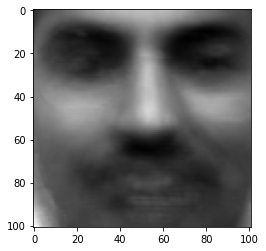

In [6]:
mean_vector_image = mean_vector.reshape((-1,101))
plt.imshow(mean_vector_image,cmap='gray')

###  2.Computing X

In [7]:
def compute_mean_centered_data(data,mean_vec):
    mean_centered_data = None
    for i in range(len(data)):
        tmp = data[i]
        tmp = tmp - mean_vec
        if(mean_centered_data is  None):
            mean_centered_data = tmp
        else:
            mean_centered_data = np.append(mean_centered_data,tmp,axis=0)
    return mean_centered_data

mean_centered_train_data = compute_mean_centered_data(train_dataset,mean_vector)
print("X = " + str(mean_centered_train_data))
print("\nShape of the mean centered data = " + str(mean_centered_train_data.shape))

X = [[-36.65 -46.   -53.85 ...  19.75 104.85 136.45]
 [-34.65 -32.   -24.85 ...  61.75 116.85 136.45]
 [ 73.35  76.    75.15 ...  -6.25 -15.15 -23.55]
 ...
 [-19.65 -12.    -3.85 ... -67.25 -78.15 -86.55]
 [ 40.35  37.    37.15 ...   7.75   6.85 -15.55]
 [-42.65 -42.   -39.85 ... -40.25 -51.15 -64.55]]

Shape of the mean centered data = (20, 10201)


In [8]:
# Computing (1/N) XX^T and print its first row
xx_t = np.matmul(mean_centered_train_data,mean_centered_train_data.transpose())
xx_t = xx_t*(1.0/train.N)
print("Shape of (1/N)* XX^T = " + str(xx_t.shape))
print(xx_t[0]) # First row of XX^T

Shape of (1/N)* XX^T = (20, 20)
[ 731508.168875 -180654.846125 -338441.901125  538707.538875
  -63182.228625  -75809.243625  128088.476375   96218.301375
 -138901.976125 -301318.953625  -15370.403625   31726.568875
 -107096.776125  -45149.133625  -12111.113625  -26296.966125
  -59854.646125  -98461.063625 -108829.173625   45229.371375]


### 3. Eigen Analysis on ((1/N)* XX^T)

In [9]:
eigen_values, eigen_vectors = np.linalg.eigh(xx_t)


# Sort the eigen values and vectors by decreasing eigen values
indices = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[indices]
eigen_vectors = eigen_vectors[:,indices]


print("\nLargest Eigen Value = " + str(eigen_values[0])) # Print the largest eigen value 
print("\nEigen Vector corresponding to the largest eigen value\n\n" + str(eigen_vectors[:,1])) # The eigen vector corresponding to eigen value eigen_values[0]

print("\nEigen Values in Descending Order\n")
for i in range(len(eigen_values)):
    print(eigen_values[i])
print("\n")


Largest Eigen Value = 4067593.362514747

Eigen Vector corresponding to the largest eigen value

[ 0.18949923 -0.15876463 -0.24148989  0.16378171 -0.49861199 -0.16148795
  0.37947542  0.09795291  0.19686721  0.16096035 -0.04252438  0.07470279
  0.21053479  0.14718294 -0.27895356 -0.27200181  0.15255082  0.04979716
 -0.30325338  0.13378227]

Eigen Values in Descending Order

4067593.362514747
1966107.3063327337
1623462.5813724461
966801.0864126948
767244.6200574421
742652.4551385873
627036.6366674971
503979.38404914085
393172.88601326285
377408.96206332213
322550.2709093349
313076.557532429
237484.58799280517
211947.43070237903
180493.58881191208
169641.8139907041
144597.82477177237
123092.60960041301
86976.00756637644
3.4481217722232183e-10




We note that the variance along each principal component is very high except the last principal component.

### 4. Transform eigen vectors to the eigen vectors of the data covariance matrix

<h4 align="center"> $U_{i}=  \frac{1}{\sqrt{\lambda_{i}N}} X^{T}V_{i}$ </h4>


In [10]:
U = None

for i in range(eigen_vectors.shape[1]):
    eigen_vector = eigen_vectors[:,i].reshape((train.N,-1))# Each V_{i}
    #print(eigen_vector)
    ui = np.matmul(mean_centered_train_data.transpose(),eigen_vector)*(1.0/math.sqrt(np.abs(eigen_values[i])*train.N))
    if U is None:
        U = ui
    else:
        U = np.append(U,ui,axis=1) # U becomes a 10201*20 matrix

print(U) # Each u_{i} will be U[:,i] where 10201 is the dimension of each u_{i}

[[ 1.15826488e-03 -1.78959860e-02  2.17228753e-03 ...  1.86726779e-02
   1.60713894e-02  1.36764667e-10]
 [ 1.50926317e-03 -1.73825233e-02  1.05655270e-03 ...  1.65266462e-02
   9.05961820e-03 -1.47060697e-10]
 [ 1.97878850e-03 -1.71250715e-02  5.24904960e-04 ...  1.25831944e-02
   2.72848225e-03  3.99501081e-10]
 ...
 [-8.06398685e-04 -1.89499116e-02  3.42941717e-02 ...  1.55630749e-02
   1.22442797e-02  2.01773961e-09]
 [-4.67369271e-04 -1.92814163e-02  4.33195925e-02 ...  1.65154982e-02
   2.62994218e-02  2.70698457e-09]
 [-3.48230110e-03 -2.17133293e-02  4.31992524e-02 ...  1.95291795e-02
   3.94973998e-02  1.90490038e-09]]


In [11]:
print(U[:,0])

[ 0.00115826  0.00150926  0.00197879 ... -0.0008064  -0.00046737
 -0.0034823 ]


**K = Number of principal components chosen**

In [12]:
K = 17 #Decided after performing analysis of LDA projections on varying K
chosen_principal_components = U[:,:K]
chosen_principal_components.shape

(10201, 17)

### Project the data on to the principal components

<h4 align="center"> $y_{n}=  U^{T} (x_{n} - \bar{x})$ </h4>
where U is matrix of dimensions KxD

In [13]:
def project_data_principal_components(data,principal_components,N):
    projected_data = None
    for i in range(N):
        data_point = data[i].reshape((-1,1))
        projection = np.matmul(principal_components.transpose(),data_point)
        if projected_data is None:
            projected_data = projection
        else:
            projected_data = np.append(projected_data,projection,axis=1)
    return projected_data



pca_projected_train_data = project_data_principal_components(mean_centered_train_data,chosen_principal_components,train.N)
print(pca_projected_train_data.shape)

(17, 20)


In [14]:
#Projection of the first data point into the 
#first K principal components of decreasing eigen value

print(pca_projected_train_data[:,0])

[-1193.08200197  1188.2998885   2829.29986404  -685.63731682
   555.06912416  -332.76272668   151.45488427  -913.0827491
   326.48045196  -146.0291758    238.73766881  -466.05747951
  -623.19425976  -545.72218803   537.83088689   459.65300868
   665.33260056]


## Linear Discriminant Analysis

In Linear Discriminant Analysis for 2 class problem we project the data points on to $W$ such that 
<h4 align="center">$W \propto  S_{w}^{-1}(m_{2} - m_{1})$ </h4>

where 
<h4 align="center">$m_{1}= \frac{1}{N_{1}} \sum_{n \epsilon C_{1}} y_{n}$ </h4>

<h4 align="center">$m_{2}= \frac{1}{N_{2}} \sum_{n \epsilon C_{2}} y_{n}$ </h4>

<h4 align="center">$S_{w}= \sum^{2}_{k=1} \frac{1}{N_{k}} \sum_{n \epsilon C_{k}} (y_{n}-m_{k})(y_{n}-m{k})^{T}$ </h4>

$N_{k}$ denotes the number of data points belonging to class K.

In [15]:
pca_projected_train_data = pca_projected_train_data.transpose() # Taking transpose for performing the matrix multiplication
print(pca_projected_train_data.shape)

(20, 17)


In [16]:
# Computing m1 and m2
def create_mean_happy_sad(dataset,projected_data):
    mean_happy = np.sum(projected_data[dataset.happy_indices],axis=0)*(1.0/len(dataset.happy_indices))
    mean_sad = np.sum(projected_data[dataset.sad_indices],axis=0)*(1.0/len(dataset.sad_indices))
    return mean_happy,mean_sad

mean_happy,mean_sad = create_mean_happy_sad(train,pca_projected_train_data)
print(mean_happy)
print(mean_sad)

[-197.35958317 -638.95258043  102.36206762 -144.99668997  226.54976984
 -300.8188473    98.18956449  376.28692888   83.43507757   29.00773317
  -12.15993823 -218.53822016  206.82438227  -13.6397201    -1.26810471
  -66.25425753  -65.47233866]
[ 161.4760226   522.77938399  -83.7507826   118.63365543 -185.35890259
  246.12451143  -80.3369164  -307.87112363  -68.26506347  -23.73359986
    9.94904037  178.80399831 -169.21994913   11.15977099    1.03754022
   54.20802889   53.56827709]


Computing $S_{w}$ by taking the summation of covariance matrices of both the classes

In [17]:
def compute_Sw(dataset,projected_data,mean_happy,mean_sad):
    happy_covariance_matrix = None
    for i in range(len(dataset.happy_indices)):
        vector = (projected_data[dataset.happy_indices[i]] - mean_happy.reshape((1,-1))).reshape((-1,1))
        if happy_covariance_matrix is None:
            happy_covariance_matrix = (np.matmul(vector,vector.transpose()))#*(1.0/len(train.happy_indices))
        else:
            happy_covariance_matrix += (np.matmul(vector,vector.transpose()))#*(1.0/len(train.happy_indices))

    sad_covariance_matrix = None
    for i in range(len(train.sad_indices)):
        vector = (projected_data[dataset.sad_indices[i]] - mean_sad.reshape((1,-1))).reshape((-1,1))
        if sad_covariance_matrix is None:
            sad_covariance_matrix = (np.matmul(vector,vector.transpose()))#*(1.0/len(train.sad_indices))
        else:
            sad_covariance_matrix += (np.matmul(vector,vector.transpose()))#*(1.0/len(train.sad_indices))
    
    Sw = happy_covariance_matrix + sad_covariance_matrix
    print(Sw.shape)
    Sw_inv = np.linalg.inv(Sw)
    print(Sw_inv.shape)
    return Sw_inv
    

In [18]:
Sw_inv = compute_Sw(train,pca_projected_train_data,mean_happy,mean_sad)


(17, 17)
(17, 17)


### Finding the projection vector W

In [19]:
m2_m1 = mean_happy.reshape((-1,1))- mean_sad.reshape((-1,1))

lda_projection_vector = np.matmul(Sw_inv,m2_m1/np.linalg.norm(m2_m1))
print(lda_projection_vector)

[[-3.84451125e-08]
 [-2.57502742e-07]
 [ 4.99593999e-08]
 [-1.18834189e-07]
 [ 2.33964637e-07]
 [-3.20951839e-07]
 [ 1.24077451e-07]
 [ 5.91598151e-07]
 [ 1.68145621e-07]
 [ 6.09006643e-08]
 [-2.98713193e-08]
 [-5.53091901e-07]
 [ 6.90059839e-07]
 [-5.09914955e-08]
 [-5.56690465e-09]
 [-3.09457727e-07]
 [-3.58770347e-07]]


### Projecting all the data points onto W

In [20]:
projection_lda_train = []
for i in range(len(pca_projected_train_data)):
    projection_value = np.matmul(pca_projected_train_data[i],lda_projection_vector)[0]
    projection_lda_train.append(projection_value)
print(projection_lda_train)

[-0.000811522388995443, -0.0009413140992846617, 0.0011294698359255047, 0.0010631538069353784, 0.0009807499785211872, -0.0005748721706071203, -0.0007938149393889365, -0.0008350343263207813, -0.0008954020668664947, -0.0007756919937677891, 0.0008059455114630838, 0.0010113607591298156, -0.00018866205391415838, -0.0009702002377325318, -0.0007690520493778709, 0.0009368123549213657, 0.0003092661864987695, 0.0010015520325520149, 0.0008910097719325466, -0.0005737539116238691]


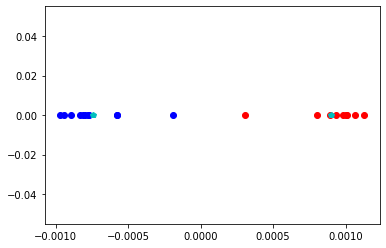

In [21]:
# Setting range for the x axis
max_value =  max(projection_lda_train) 
min_value = max(projection_lda_train)

y = 0 # Y coordinate set as 0 so that we get a number line representation

for h in train.happy_indices:
    plt.plot(projection_lda_train[h],y,'ro')  # Red for happy classes

for s in train.sad_indices:
    plt.plot(projection_lda_train[s],y,'bo') # Blue for sad classes
    

# The projection of the mean vectors onto W. represented as cyan dots
happy_mean_projection = np.matmul(mean_happy.reshape((1,-1)),lda_projection_vector)[0] 
sad_mean_projection = np.matmul(mean_sad.reshape((1,-1)),lda_projection_vector)[0]

plt.plot(happy_mean_projection,y,'cp')
plt.plot(sad_mean_projection,y,'cp')

plt.show()


We see that we are able to have a clear distinction between the happy and sad faces after projecting onto W. We can setup our discriminant as

```
if(projected_value >= 0)
    class = "happy"
else
    class = "sad"
```

Chosen Principal Components size2
(2, 2)
(2, 2)


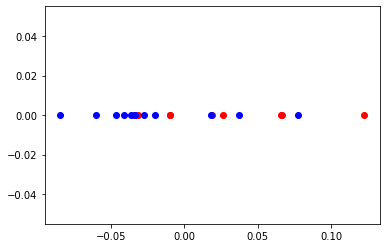

Chosen Principal Components size3
(3, 3)
(3, 3)


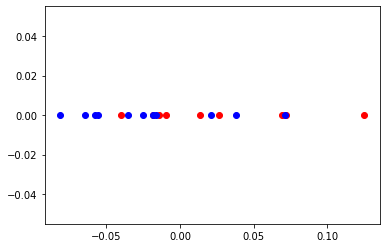

Chosen Principal Components size4
(4, 4)
(4, 4)


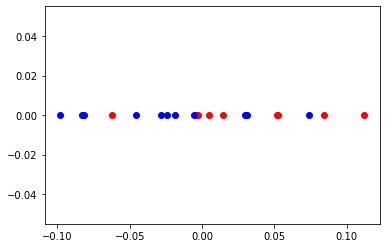

Chosen Principal Components size5
(5, 5)
(5, 5)


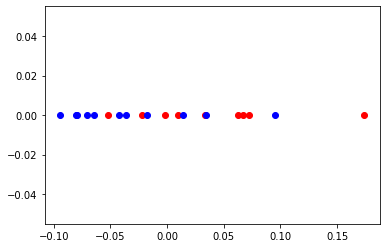

Chosen Principal Components size6
(6, 6)
(6, 6)


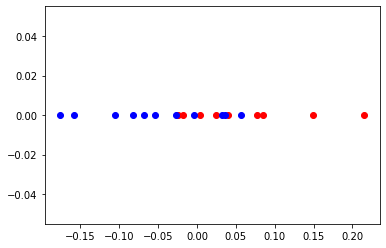

Chosen Principal Components size7
(7, 7)
(7, 7)


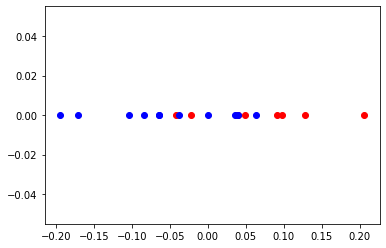

Chosen Principal Components size8
(8, 8)
(8, 8)


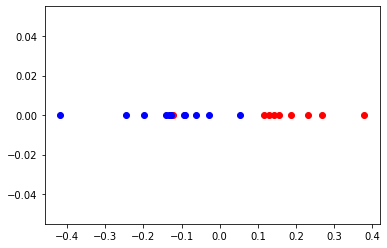

Chosen Principal Components size9
(9, 9)
(9, 9)


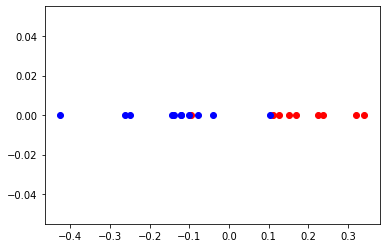

Chosen Principal Components size10
(10, 10)
(10, 10)


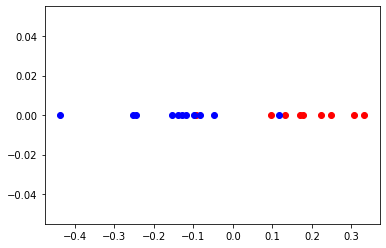

Chosen Principal Components size11
(11, 11)
(11, 11)


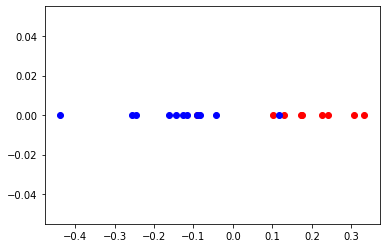

Chosen Principal Components size12
(12, 12)
(12, 12)


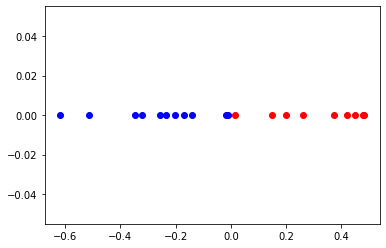

Chosen Principal Components size13
(13, 13)
(13, 13)


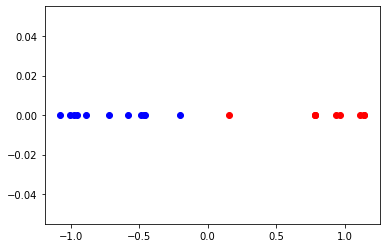

Chosen Principal Components size14
(14, 14)
(14, 14)


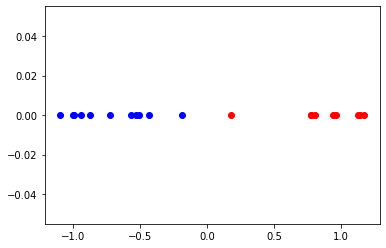

Chosen Principal Components size15
(15, 15)
(15, 15)


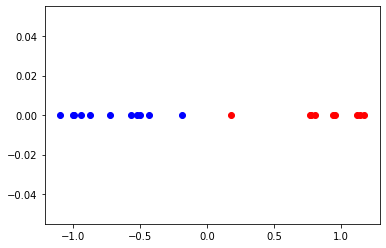

Chosen Principal Components size16
(16, 16)
(16, 16)


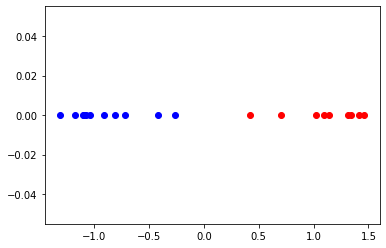

Chosen Principal Components size17
(17, 17)
(17, 17)


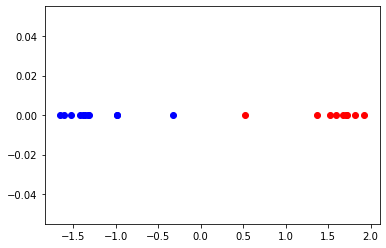

Chosen Principal Components size18
(18, 18)
(18, 18)


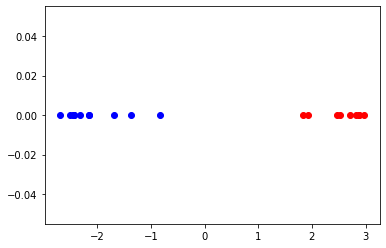

Chosen Principal Components size19
(19, 19)
(19, 19)


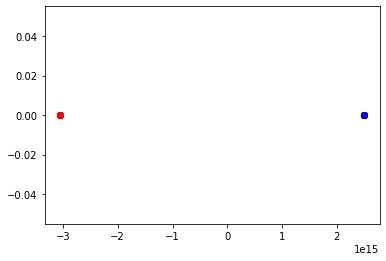

In [22]:
# Finding a suitable value of K that maximizes seperability

def plot_LDA_different_K(mean_centered_data,dataset,eigen_vectors,K):
    chosen_principal_components = eigen_vectors[:,:K]
    pca_projected_data = project_data_principal_components(mean_centered_data,chosen_principal_components,dataset.N)
    pca_projected_data = pca_projected_data.transpose()
    mean_happy,mean_sad = create_mean_happy_sad(dataset,pca_projected_data)
    Sw_inv = compute_Sw(dataset,pca_projected_data,mean_happy,mean_sad)
    lda_projection_vector = np.matmul(Sw_inv,(mean_happy.reshape((-1,1))- mean_sad.reshape((-1,1))))
    
    lda_projections = []
    for i in range(len(pca_projected_data)):
        projection_value = np.matmul(pca_projected_data[i],lda_projection_vector)[0]
        lda_projections.append(projection_value)
    
    
    # Setting range for the x axis
    max_value =  max(lda_projections) 
    min_value = max(lda_projections)

    y = 0 

    for h in dataset.happy_indices:
        plt.plot(lda_projections[h],y,'ro')  

    for s in dataset.sad_indices:
        plt.plot(lda_projections[s],y,'bo') 
    
    happy_mean_projection = np.matmul(mean_happy.reshape((1,-1)),lda_projection_vector)[0] 
    sad_mean_projection = np.matmul(mean_sad.reshape((1,-1)),lda_projection_vector)[0]

    #plt.plot(happy_mean_projection,y,'cp')
    #plt.plot(sad_mean_projection,y,'cp')

    plt.show()

    

for i in range(2,20):
    print("Chosen Principal Components size" + str(i))
    plot_LDA_different_K(mean_centered_train_data,train,U,i)    

Based on the gap between the extreme endpoints 17 was decided for the number of principal components to use.

### Testing the Discriminant on the test dataset

In [23]:
test = Dataset("test/")
test_dataset = test.getDataset()
print(test_dataset.shape)

(10, 10201)


In [24]:
# Subtract from the mean vector generated during training and create the mean centered test dataset
mean_centered_test_data = None
for i in range(len(test_dataset)):
    tmp = test_dataset[i]
    tmp = tmp - mean_vector
    if(mean_centered_test_data is  None):
        mean_centered_test_data = tmp
    else:
        mean_centered_test_data = np.append(mean_centered_test_data,tmp,axis=0)


print(mean_centered_test_data.shape)

(10, 10201)


In [25]:
#Project the mean centered data onto the principal components derived from the training set
pca_projected_test_data = np.matmul(mean_centered_test_data,chosen_principal_components)
print(pca_projected_test_data.shape)

(10, 17)


In [26]:
# Perform LDA on the test dataset using lda_projection vector derived from the training set
projection_lda_test = []
for i in range(len(pca_projected_test_data)):
    projection_value = np.matmul(pca_projected_test_data[i],lda_projection_vector)[0]
    projection_lda_test.append(projection_value)
print(projection_lda_test)

[0.0002714343406944489, 0.0006417924100201155, -0.000935678714548345, -0.00037178317881557925, 0.0001615649700147187, -0.0006899903207635916, 0.0011401470895342188, 0.0004742876409438657, -0.0006300197532437273, 7.261167173241585e-06]


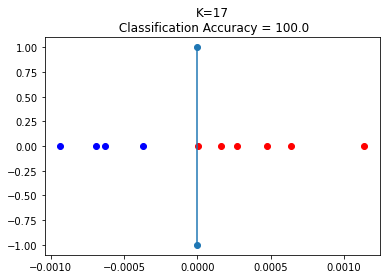

Classification Accuracy = 100.0


In [27]:
# Perform classification on the basis of projection made to W vector

max_value =  max(projection_lda_test)
min_value = max(projection_lda_test)

misclassification_error = 0

for i in range(len(test_dataset)):
    if(projection_lda_test[i]>= 0):
        predicted_class = 'happy'
    else:
        predicted_class = 'sad'
        
        
    if i in test.happy_indices:
        actual_class ='happy' 
    else:
        actual_class = 'sad'
    
    if(predicted_class!=actual_class):
        misclassification_error+=1
        if(actual_class=='happy'):
            plt.plot(projection_lda_test[i],y,'rx')
        else:
            plt.plot(projection_lda_test[i],y,'bx')
    else:
        if (actual_class=='happy'):
            plt.plot(projection_lda_test[i],y,'ro')
        else:
            plt.plot(projection_lda_test[i],y,'bo')

classification_accuracy = (float(len(test_dataset)-misclassification_error))/(len(test_dataset)) * 100
plt.plot([0, 0], [1, -1], marker = 'o')
plt.title("K=" + str(K) + "\n Classification Accuracy = " + str(classification_accuracy))

plt.show()   
print("Classification Accuracy = " + str(classification_accuracy))